In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('olist_customers_dataset.csv', 'olist_customers_dataset'),
    ('olist_orders_dataset.csv', 'olist_orders_dataset'),
    ('olist_sellers_dataset.csv', 'olist_sellers_dataset'),
    ('olist_products_dataset.csv', 'olist_products_dataset'),
    ('olist_geolocation_dataset.csv', 'olist_geolocation_dataset'),
    ('olist_order_payments_dataset.csv', 'olist_order_payments_dataset'),  # Added payments.csv for specific handling
    ('olist_order_items_dataset.csv', 'olist_order_items_dataset'),
    ('olist_order_reviews_dataset.csv', 'olist_order_reviews_dataset'),
    ('product_category_name_translation.csv', 'product_category_name_translation')
    
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='12345',
    database='EcommerceBrazil'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Vikash/Desktop/python file/EcommerceBrazil'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing olist_customers_dataset.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing olist_orders_dataset.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing olist_sellers_dataset.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing olist_products_dataset.csv
NaN values before replacement:
product_id                      0
product_category_name         610
product_name_lenght           610
product_descript

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "12345",
                             database = "EcommerceBrazil")
cur = db.cursor()

### 1. List all unique cities where customers are located.

In [ ]:
query = """ select distinct customer_city from olist_customers_dataset; """
cur.execute(query)
data = cur.fetchall()
data

### no of customers from each state

In [5]:
query = """ select distinct customer_state, count(customer_id) as NO_of_customers from olist_customers_dataset
group by customer_state
order by NO_of_customers desc; """
cur.execute(query)
data = cur.fetchall()
data
# and if i want to dataframe
df = pd.DataFrame(data, columns = ["State", "NO_of_customers"])
df

,State,NO_of_customers
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045
5,SC,3637
6,BA,3380
7,DF,2140
8,ES,2033
9,GO,2020


### * count all unique cities where customers are located.

In [4]:
query = """ select distinct count(customer_city) from olist_customers_dataset; """
cur.execute(query)
data = cur.fetchall()
data


[(99441,)]

### 2. Count the number of orders placed in 2017.

In [6]:
query = """ select count(order_id) from olist_orders_dataset where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

### Count the number of orders placed in 2018

In [8]:
query = """ select count(order_id) from olist_orders_dataset where year(order_purchase_timestamp) = 2018 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2018 are", data[0][0]

('total orders placed in 2017 are', 54011)

### Count the number of orders placed in 2016

In [9]:
query = """ select count(order_id) from olist_orders_dataset where year(order_purchase_timestamp) = 2016 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2016 are", data[0][0]

('total orders placed in 2017 are', 329)

### Find the total sales per month

In [13]:
query = """
SELECT 
    YEAR(order_purchase_timestamp) AS year,
    MONTH(order_purchase_timestamp) AS month,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS total_sales
FROM 
    olist_orders_dataset
JOIN 
    olist_order_payments_dataset
ON 
    olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
WHERE 
    YEAR(order_purchase_timestamp) IN (2016, 2017, 2018)
GROUP BY 
    YEAR(order_purchase_timestamp), MONTH(order_purchase_timestamp)
ORDER BY 
    YEAR(order_purchase_timestamp), MONTH(order_purchase_timestamp)
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Year", "Month", "Total_Sales"])
df


,Year,Month,Total_Sales
0,2016,9,252.24
1,2016,10,59090.48
2,2016,12,19.62
3,2017,1,138488.04
4,2017,2,291908.01
5,2017,3,449863.60
6,2017,4,417788.03
7,2017,5,592918.82
8,2017,6,511276.38
9,2017,7,592382.92


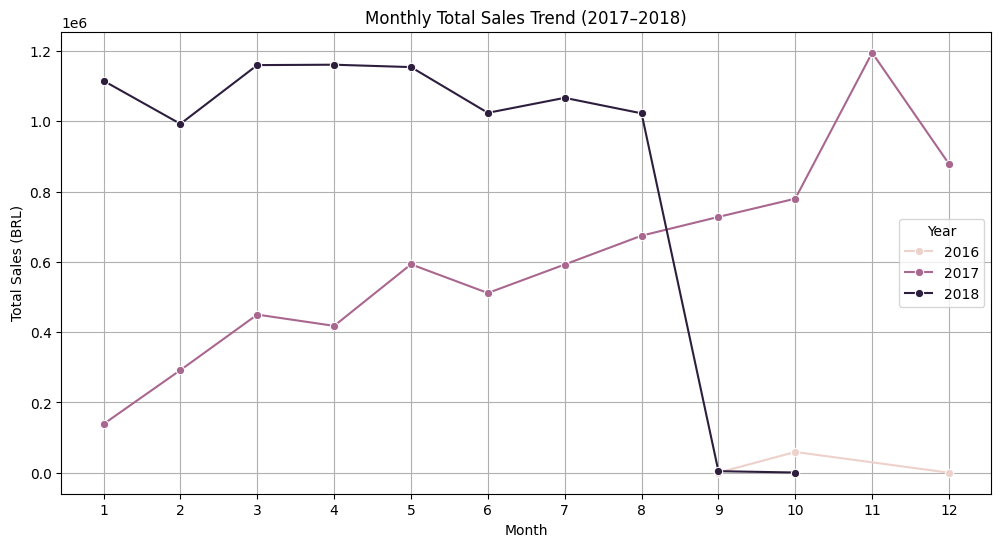

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Month", y="Total_Sales", hue="Year", marker="o")
plt.title("Monthly Total Sales Trend (2017–2018)")
plt.xlabel("Month")
plt.ylabel("Total Sales (BRL)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


In [ ]:
total sales per year

In [4]:
query = """
SELECT 
    YEAR(olist_orders_dataset.order_purchase_timestamp) AS Year,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Total_Sales
FROM 
    olist_orders_dataset
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
WHERE 
    olist_orders_dataset.order_status = 'delivered'
GROUP BY 
    YEAR(olist_orders_dataset.order_purchase_timestamp)
ORDER BY 
    Year
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Total_Sales"])
df


,Year,Total_Sales
0,2016,46586.33
1,2017,6922900.24
2,2018,8452975.20


### 3. Find the total sales per category.


In [6]:
query = """ select olist_products_dataset.product_category_name as category, round(sum(olist_order_payments_dataset.payment_value),2) as sales
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_payments_dataset
on olist_order_payments_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name
order by sales Desc
"""# you can use limit also

cur.execute(query)
data = cur.fetchall()
data
# and if i want to dataframe
df = pd.DataFrame(data, columns = ["Category", "sales"])
df

,Category,sales
0,cama_mesa_banho,1712553.67
1,beleza_saude,1657373.12
2,informatica_acessorios,1585330.45
3,moveis_decoracao,1430176.39
4,relogios_presentes,1429216.68
...,...,...
69,pc_gamer,2174.43
70,casa_conforto_2,1710.54
71,cds_dvds_musicais,1199.43
72,fashion_roupa_infanto_juvenil,785.67


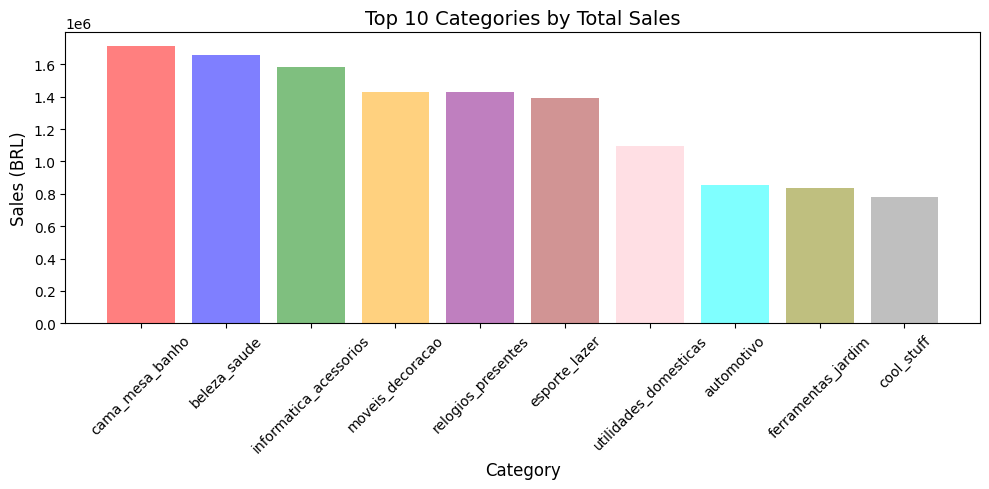

In [19]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'olive', 'grey']

# Show top 10 categories by sales
top10_df = df.sort_values(by="sales", ascending=False).head(10)

# Create color map (can use 'viridis', 'plasma', 'tab10', etc.)
# colors = plt.cm.tab10(range(len(top10_df)))

plt.figure(figsize=(10, 5))
plt.bar(top10_df["Category"], top10_df["sales"], color=colors,alpha=0.5)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Sales (BRL)", fontsize=12)
plt.title("Top 10 Categories by Total Sales", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Find the total sales per category (category name in english)

In [14]:
query = """
SELECT 
    product_category_name_translation.product_category_name_english AS Category,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Sales
FROM 
    olist_products_dataset
JOIN 
    product_category_name_translation 
    ON olist_products_dataset.product_category_name = product_category_name_translation.product_category_name
JOIN 
    olist_order_items_dataset 
    ON olist_products_dataset.product_id = olist_order_items_dataset.product_id
JOIN 
    olist_order_payments_dataset 
    ON olist_order_items_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    product_category_name_translation.product_category_name_english
ORDER BY 
    Sales DESC
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Sales"])
df


,Category,Sales
0,bed_bath_table,1712553.67
1,health_beauty,1657373.12
2,computers_accessories,1585330.45
3,furniture_decor,1430176.39
4,watches_gifts,1429216.68
...,...,...
66,flowers,2213.01
67,home_comfort_2,1710.54
68,cds_dvds_musicals,1199.43
69,fashion_childrens_clothes,785.67


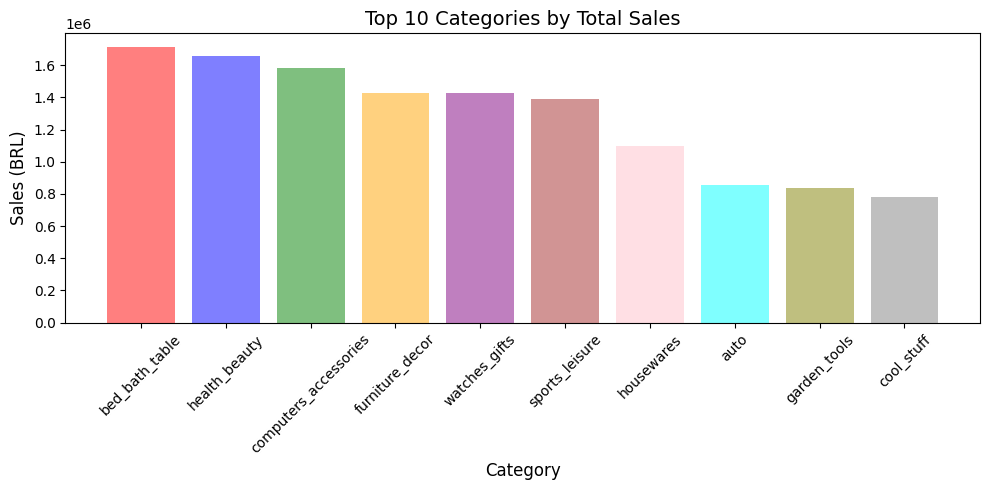

In [10]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan', 'olive', 'grey']

# Show top 10 categories by sales
top10_df = df.sort_values(by="Sales", ascending=False).head(10)

# Create color map (can use 'viridis', 'plasma', 'tab10', etc.)
# colors = plt.cm.tab10(range(len(top10_df)))

plt.figure(figsize=(10, 5))
plt.bar(top10_df["Category"], top10_df["Sales"], color=colors,alpha=0.5)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Sales (BRL)", fontsize=12)
plt.title("Top 10 Categories by Total Sales", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sum of sales and much profits per category

In [17]:
query = """
SELECT 
    product_category_name_translation.product_category_name_english AS Category,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Sales,
    ROUND(SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price), 2) AS Profit,
    ROUND(
        (SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price) 
         / NULLIF(SUM(olist_order_payments_dataset.payment_value), 0)) * 100, 2
    ) AS Profit_Percentage
FROM 
    olist_products_dataset
JOIN 
    product_category_name_translation 
    ON olist_products_dataset.product_category_name = product_category_name_translation.product_category_name
JOIN 
    olist_order_items_dataset 
    ON olist_products_dataset.product_id = olist_order_items_dataset.product_id
JOIN 
    olist_order_payments_dataset 
    ON olist_order_items_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    product_category_name_translation.product_category_name_english
ORDER BY 
    Profit DESC
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Sales", "Profit", "Profit_Percentage"])
df


,Category,Sales,Profit,Profit_Percentage
0,furniture_decor,1430176.39,665082.50,46.50
1,computers_accessories,1585330.45,643052.88,40.56
2,bed_bath_table,1712553.67,620002.65,36.20
3,housewares,1094758.13,428171.13,39.11
4,sports_leisure,1392127.56,368131.22,26.44
...,...,...,...,...
66,la_cuisine,2913.53,609.55,20.92
67,arts_and_craftmanship,2326.17,512.16,22.02
68,cds_dvds_musicals,1199.43,469.43,39.14
69,fashion_childrens_clothes,785.67,215.82,27.47


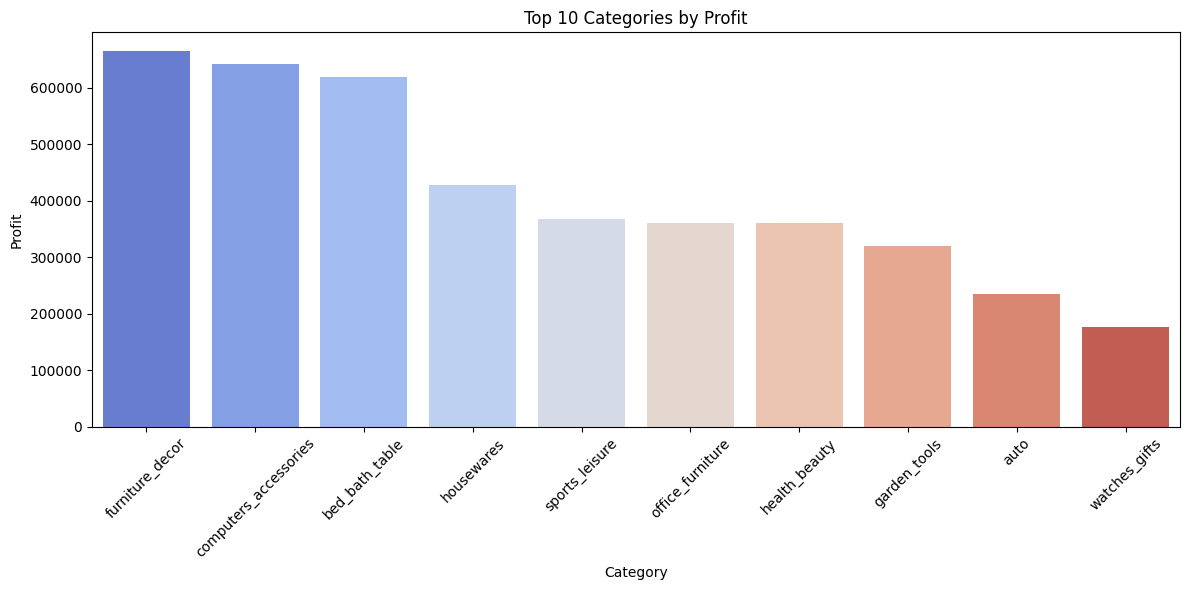

In [23]:
# Plot top 10 categories by profit (clean, no warning)
plt.figure(figsize=(12,6))
sns.barplot(data=df.sort_values('Profit', ascending=False).head(10), 
            x='Category', y='Profit', hue='Category', palette='coolwarm', legend=False)

plt.title('Top 10 Categories by Profit')
plt.xlabel('Category')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sum of sales and much profits_percentage per category

In [16]:
query = """
SELECT 
    product_category_name_translation.product_category_name_english AS Category,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Sales,
    ROUND(SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price), 2) AS Profit,
    ROUND(
        (SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price) 
         / NULLIF(SUM(olist_order_payments_dataset.payment_value), 0)) * 100, 2
    ) AS Profit_Percentage
FROM 
    olist_products_dataset
JOIN 
    product_category_name_translation 
    ON olist_products_dataset.product_category_name = product_category_name_translation.product_category_name
JOIN 
    olist_order_items_dataset 
    ON olist_products_dataset.product_id = olist_order_items_dataset.product_id
JOIN 
    olist_order_payments_dataset 
    ON olist_order_items_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    product_category_name_translation.product_category_name_english
ORDER BY 
    Profit_Percentage DESC
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Sales", "Profit", "Profit_Percentage"])
df

,Category,Sales,Profit,Profit_Percentage
0,fixed_telephony,207010.26,145309.00,70.19
1,signaling_and_security,68488.05,46903.24,68.48
2,drinks,71429.65,48575.09,68.00
3,diapers_and_hygiene,4221.25,2653.66,62.86
4,office_furniture,646826.49,360667.53,55.76
...,...,...,...,...
66,small_appliances,225584.38,24667.72,10.94
67,musical_instruments,233074.12,22145.39,9.50
68,music,6901.43,643.23,9.32
69,small_appliances_home_oven_and_coffee,51229.32,2283.61,4.46


### Sum of sales and profits per category

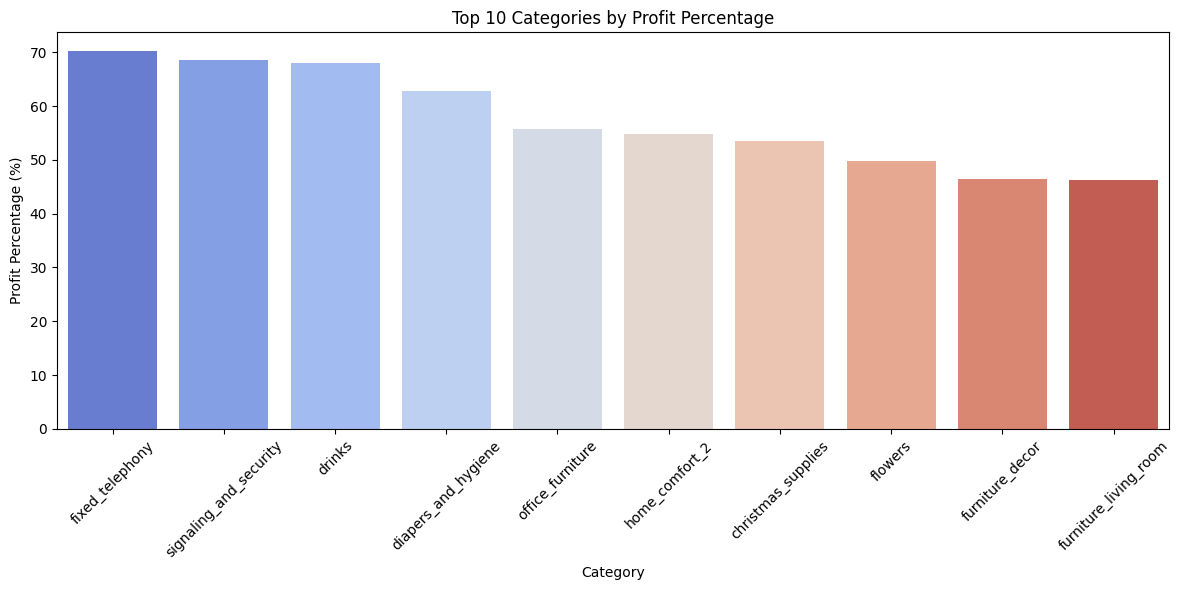

In [18]:
# Plot top 10 categories by profit percentage (clean, no warning)
plt.figure(figsize=(12,6))
sns.barplot(data=df.sort_values('Profit_Percentage', ascending=False).head(10), 
            x='Category', y='Profit_Percentage', hue='Category', palette='coolwarm', legend=False)

plt.title('Top 10 Categories by Profit Percentage')
plt.xlabel('Category')
plt.ylabel('Profit Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Calculate the percentage of orders that were paid in installments.

### 5. Count the number of customers from each state. 

In [22]:
query = """ select customer_state, count(customer_id)
from olist_customers_dataset
group by customer_state; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["State", "NO_of_customers"])
df

,State,NO_of_customers
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852
5,RS,5466
6,PA,975
7,GO,2020
8,ES,2033
9,BA,3380


<function matplotlib.pyplot.show(close=None, block=None)>

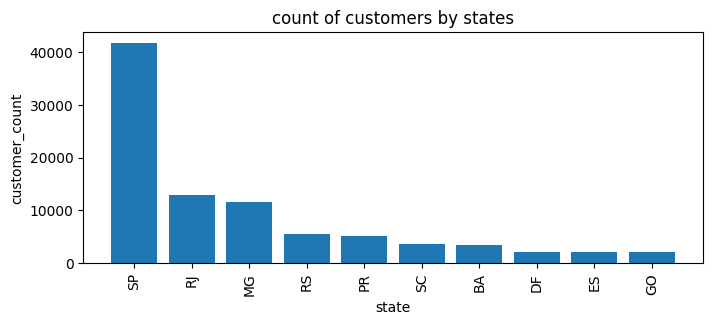

In [23]:
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False).head(10)
df
plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xlabel("state")
plt.ylabel("customer_count")
plt.title("count of customers by states")
plt.xticks(rotation = 90)
plt.show 

### 1. Calculate the number of orders per month in 2018.

In [27]:
query = """
SELECT 
    MONTHNAME(order_purchase_timestamp) AS Month_Name,
    COUNT(order_id) AS Order_Count
FROM 
    olist_orders_dataset
WHERE 
    YEAR(order_purchase_timestamp) = 2018
GROUP BY 
    MONTH(order_purchase_timestamp), MONTHNAME(order_purchase_timestamp)
ORDER BY 
    MONTH(order_purchase_timestamp)
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Month", "Order_Count"])
df


,Month,Order_Count
0,January,7269
1,February,6728
2,March,7211
3,April,6939
4,May,6873
5,June,6167
6,July,6292
7,August,6512
8,September,16
9,October,4


C:\Users\Vikash\AppData\Local\Temp\ipykernel_21444\3244829323.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Order_Count', data=df, palette='coolwarm')


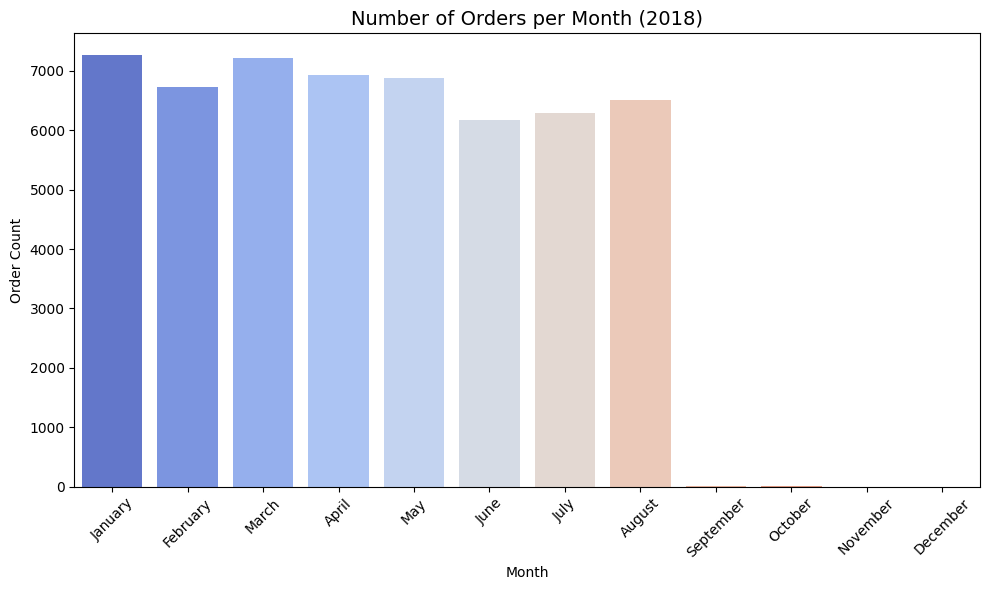

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure months are in correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Set the order for the x-axis
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
df = df.sort_values('Month')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Order_Count', data=df, palette='coolwarm')
plt.title('Number of Orders per Month (2018)', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Order Count')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


### 2.Find the average number of products per order, grouped by customer city.

In [15]:
query = """ with count_per_order as
(select olist_orders_dataset.order_id, olist_orders_dataset.customer_id, count(olist_order_items_dataset.order_id) as oc
from olist_orders_dataset join olist_order_items_dataset
on olist_orders_dataset.order_id = olist_order_items_dataset.order_id
group by olist_orders_dataset.order_id, olist_orders_dataset.customer_id)

select olist_customers_dataset.customer_city, round(avg(count_per_order.oc),2) average_orders
from olist_customers_dataset join count_per_order 
on olist_customers_dataset.customer_id = count_per_order.customer_id
group by olist_customers_dataset.customer_city order by average_orders desc;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["customer_city", "average_product/order"])
df
df.head(10)

,customer_city,average_product/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [23]:
query = """ select olist_products_dataset.product_category_name, 
round((sum(olist_order_payments_dataset.payment_value)/ (select sum(payment_value) from olist_order_payments_dataset))*100,2) sales
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_payments_dataset
on olist_order_payments_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name
order by sales desc;"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["category", "percentage_distribution"])
df



,category,percentage_distribution
0,cama_mesa_banho,10.70
1,beleza_saude,10.35
2,informatica_acessorios,9.90
3,moveis_decoracao,8.93
4,relogios_presentes,8.93
...,...,...
69,casa_conforto_2,0.01
70,cds_dvds_musicais,0.01
71,pc_gamer,0.01
72,fashion_roupa_infanto_juvenil,0.00


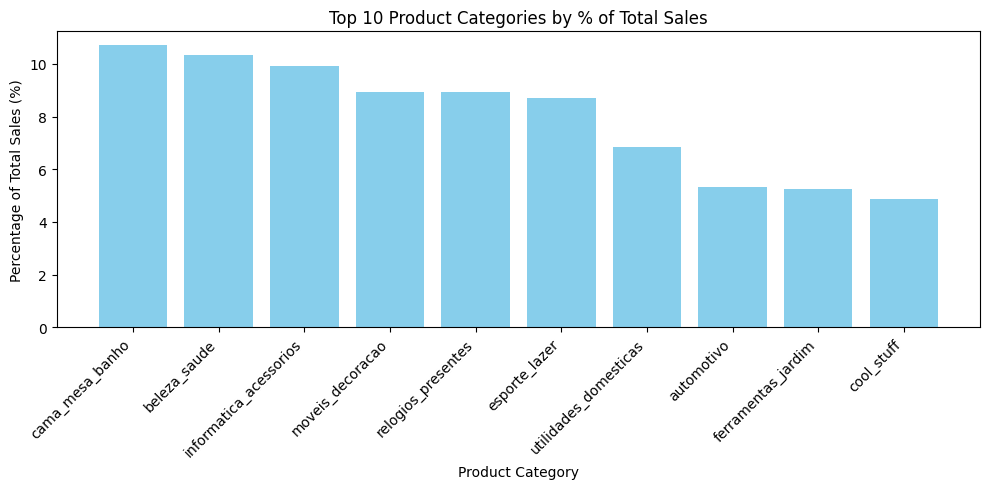

In [19]:
df_top10 = df.head(10)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df_top10["category"], df_top10["percentage_distribution"], color='skyblue')
plt.xlabel("Product Category")
plt.ylabel("Percentage of Total Sales (%)")
plt.title("Top 10 Product Categories by % of Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [27]:
query = """ select olist_products_dataset.product_category_name, 
count(olist_order_items_dataset.product_id), 
round(avg(olist_order_items_dataset.price),2) 
from olist_products_dataset join olist_order_items_dataset 
on olist_products_dataset.product_id = olist_order_items_dataset.product_id 
group by olist_products_dataset.product_category_name ;"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["product_category_name", " order_count", "price"])
df
arr1 = df[" order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][-1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

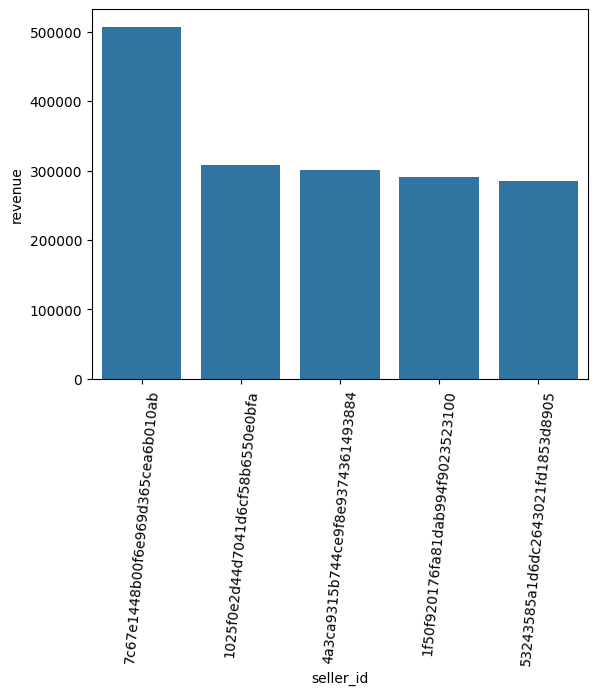

In [37]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from 
(select olist_order_items_dataset.seller_id, sum(olist_order_payments_dataset.payment_value) 
revenue from olist_order_items_dataset join olist_order_payments_dataset 
on olist_order_items_dataset.order_id = olist_order_payments_dataset.order_id 
group by olist_order_items_dataset.seller_id) as a """ 
cur.execute(query) 
data = cur.fetchall() 
df = pd.DataFrame (data, columns = ["seller_id", "revenue", "rank"]) 
df = df.head() 
sns.barplot(x = "seller_id", y = "revenue", data = df) 
plt.xticks(rotation = 85) 
plt.show()

### 1. Calculate the moving average of order values for each customer over their order history.

### 2. Calculate the cumulative sales per month for each year.

In [38]:
query = """
SELECT 
    YEAR(o.order_purchase_timestamp) AS Year,
    MONTHNAME(o.order_purchase_timestamp) AS Month,
    ROUND(SUM(p.payment_value), 2) AS Monthly_Sales,
    ROUND(SUM(SUM(p.payment_value)) OVER (
        PARTITION BY YEAR(o.order_purchase_timestamp)
        ORDER BY MONTH(o.order_purchase_timestamp)
    ), 2) AS Cumulative_Sales
FROM 
    olist_orders_dataset o
JOIN 
    olist_order_payments_dataset p
    ON o.order_id = p.order_id
GROUP BY 
    YEAR(o.order_purchase_timestamp), MONTH(o.order_purchase_timestamp), MONTHNAME(o.order_purchase_timestamp)
ORDER BY 
    Year, MONTH(o.order_purchase_timestamp)
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Month", "Monthly_Sales", "Cumulative_Sales"])
df


,Year,Month,Monthly_Sales,Cumulative_Sales
0,2016,September,252.24,252.24
1,2016,October,59090.48,59342.72
2,2016,December,19.62,59362.34
3,2017,January,138488.04,138488.04
4,2017,February,291908.01,430396.05
5,2017,March,449863.60,880259.65
6,2017,April,417788.03,1298047.68
7,2017,May,592918.82,1890966.50
8,2017,June,511276.38,2402242.88
9,2017,July,592382.92,2994625.80


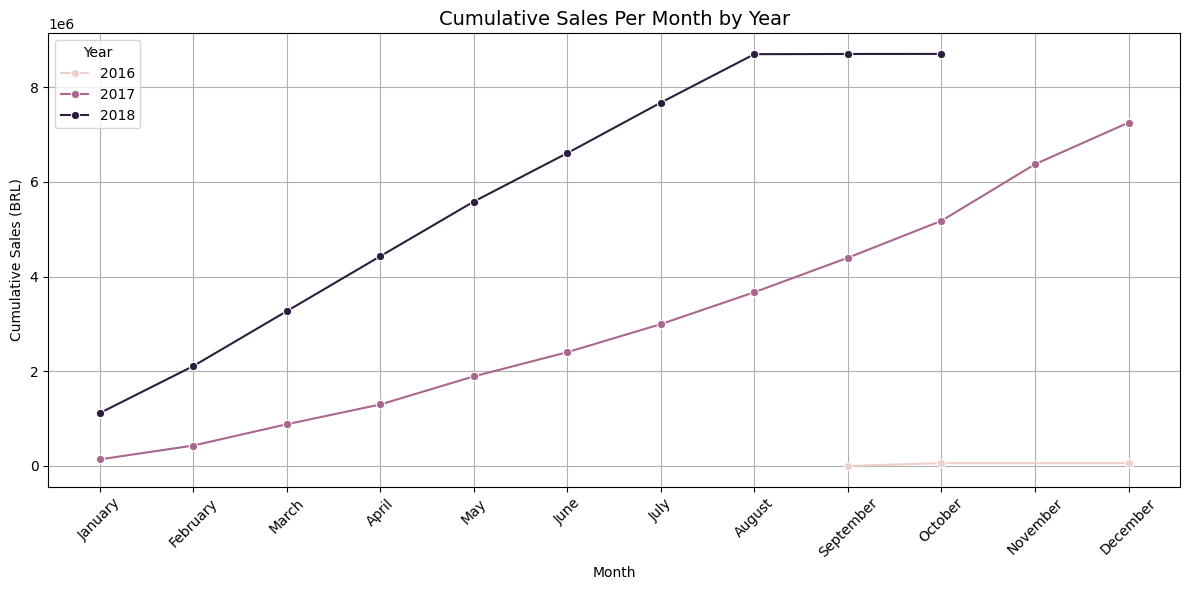

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: to make sure months are ordered properly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
df = df.sort_values(['Year', 'Month'])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Month', y='Cumulative_Sales', hue='Year', marker='o')
plt.title('Cumulative Sales Per Month by Year', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Cumulative Sales (BRL)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Calculate the year-over-year growth rate of total sales.

In [40]:
query = """
WITH yearly_sales AS (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS Year,
        ROUND(SUM(p.payment_value), 2) AS Total_Sales
    FROM 
        olist_orders_dataset o
    JOIN 
        olist_order_payments_dataset p
        ON o.order_id = p.order_id
    GROUP BY 
        YEAR(o.order_purchase_timestamp)
)

SELECT 
    y.Year,
    y.Total_Sales,
    ROUND(((y.Total_Sales - LAG(y.Total_Sales) OVER (ORDER BY y.Year)) / 
           LAG(y.Total_Sales) OVER (ORDER BY y.Year)) * 100, 2) AS YoY_Growth_Percentage
FROM 
    yearly_sales y
ORDER BY 
    y.Year
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Total_Sales", "YoY_Growth_Percentage"])
df


,Year,Total_Sales,YoY_Growth_Percentage
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

### 5. Identify the top 3 customers who spent the most money in each year.

# chatGPT

### 1. What are the unique product categories available?

In [43]:
query = """ select distinct(product_category_name) as products from olist_products_dataset;"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["products"])
df

,products
0,perfumaria
1,artes
2,esporte_lazer
3,bebes
4,utilidades_domesticas
...,...
69,casa_conforto_2
70,portateis_cozinha_e_preparadores_de_alimentos
71,seguros_e_servicos
72,moveis_colchao_e_estofado


### 2. How many sellers are there in the dataset?

In [86]:
query = """ select count(distinct(seller_id)) as total_sellers from olist_sellers_dataset """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["total_sellers"])
df
df.head()

,total_sellers
0,3095


### 3. Find the number of orders per payment type.

In [8]:
query = """ select count(order_id), payment_type from olist_order_payments_dataset
group by payment_type
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","payment_type"])
df

,order_id,payment_type
0,76795,credit_card
1,19784,boleto
2,5775,voucher
3,1529,debit_card
4,3,not_defined


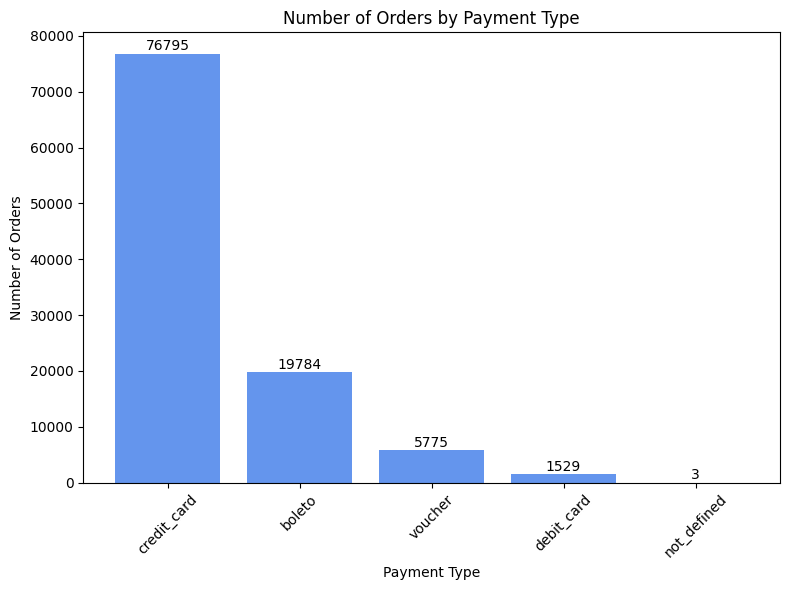

In [9]:
import matplotlib.pyplot as plt

# Sort by order count for better visual
df_sorted = df.sort_values("order_id", ascending=False)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(df_sorted["payment_type"], df_sorted["order_id"], color="cornflowerblue")

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f"{int(yval)}", ha='center', va='bottom')

# Customize chart
plt.xlabel("Payment Type")
plt.ylabel("Number of Orders")
plt.title("Number of Orders by Payment Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. List the top 10 cities with the highest number of orders.

In [45]:
query = """ select olist_customers_dataset.customer_city as city, count(olist_orders_dataset.order_id) as total_orders
from olist_customers_dataset join olist_orders_dataset
on olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
group by city
order by total_orders desc
limit 10;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["city","total_orders"])
df

,city,total_orders
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


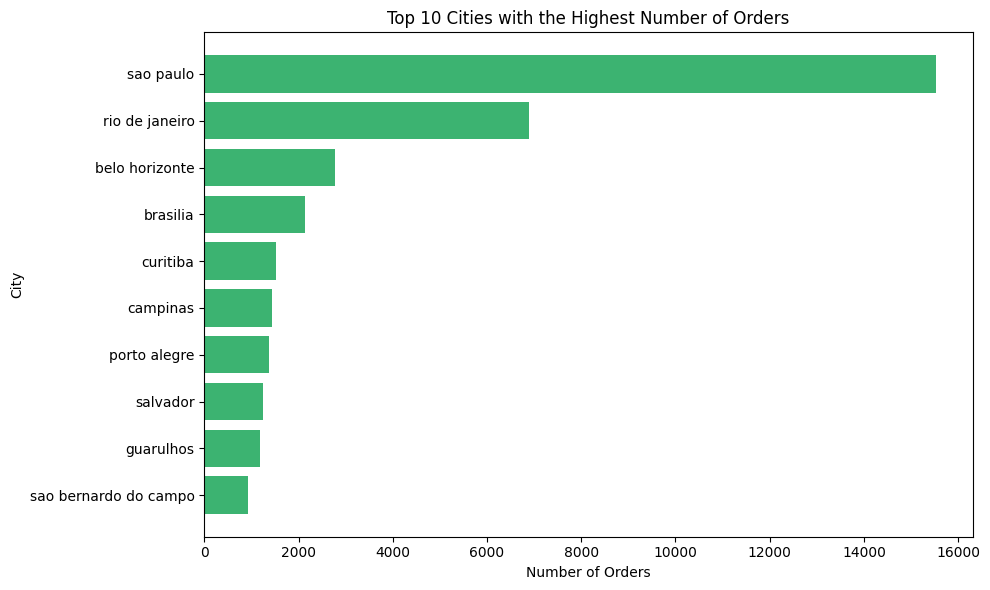

In [114]:
plt.figure(figsize=(10, 6))
plt.barh(df["city"], df["total_orders"], color="mediumseagreen")
plt.xlabel("Number of Orders")
plt.ylabel("City")
plt.title("Top 10 Cities with the Highest Number of Orders")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()


### group by sales

In [59]:
query = """
WITH city_metrics AS (
    SELECT 
        c.customer_city AS City,
        COUNT(DISTINCT o.order_id) AS Total_Orders,
        ROUND(SUM(p.payment_value), 2) AS Total_Sales,
        ROUND(SUM(p.payment_value - i.price), 2) AS Profit,
        ROUND(
            (SUM(p.payment_value - i.price) / NULLIF(SUM(p.payment_value), 0)) * 100, 
            2
        ) AS Profit_Percentage
    FROM 
        olist_customers_dataset c
    JOIN 
        olist_orders_dataset o ON c.customer_id = o.customer_id
    JOIN 
        olist_order_items_dataset i ON o.order_id = i.order_id
    JOIN 
        olist_order_payments_dataset p ON o.order_id = p.order_id
    GROUP BY 
        c.customer_city
)

SELECT 
    City,
    Total_Orders,
    Total_Sales,
    Profit,
    Profit_Percentage
FROM 
    city_metrics
ORDER BY 
    Total_Sales DESC
LIMIT 10
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["City", "Total_Orders", "Total_Sales", "Profit", "Profit_Percentage"])
df


,City,Total_Orders,Total_Sales,Profit,Profit_Percentage
0,sao paulo,15402,2839903.47,831649.08,29.28
1,rio de janeiro,6834,1566591.49,535875.65,34.21
2,belo horizonte,2750,501261.50,134280.17,26.79
3,brasilia,2116,430499.43,118224.86,27.46
4,curitiba,1510,329321.54,110789.07,33.64
5,porto alegre,1372,315729.22,120093.64,38.04
6,salvador,1238,289139.66,92464.11,31.98
7,campinas,1429,267039.20,71412.71,26.74
8,goiania,687,212702.97,98304.92,46.22
9,guarulhos,1178,205350.25,50133.40,24.41


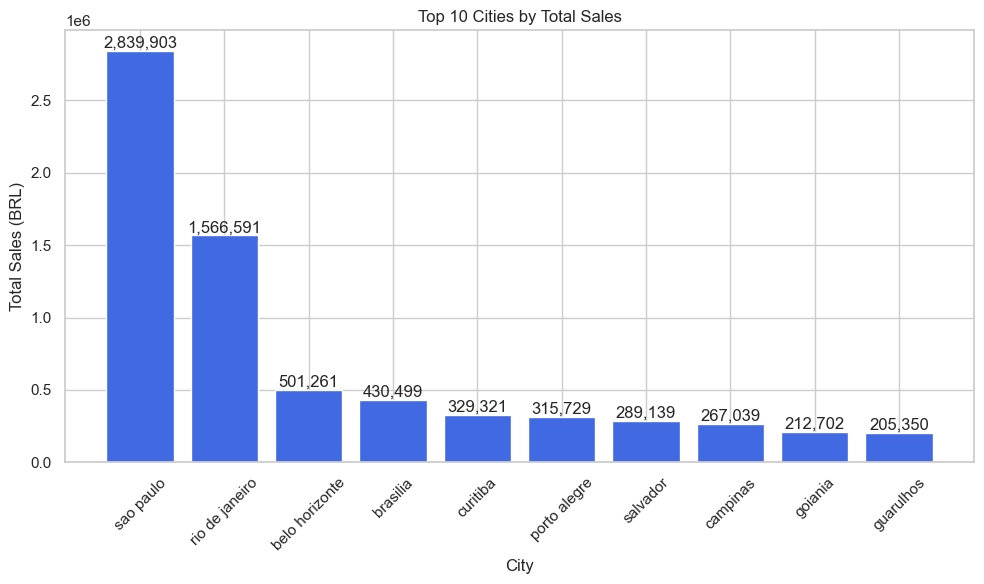

In [60]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df["City"], df["Total_Sales"], color="royalblue")

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, f"{int(yval):,}", ha='center', va='bottom')

plt.xlabel("City")
plt.ylabel("Total Sales (BRL)")
plt.title("Top 10 Cities by Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### group by profit

In [62]:
query = """
SELECT 
    olist_customers_dataset.customer_city AS City,
    COUNT(DISTINCT olist_orders_dataset.order_id) AS Total_Orders,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Total_Sales,
    ROUND(SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price), 2) AS Profit,
    ROUND(
        (SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price) / 
         NULLIF(SUM(olist_order_payments_dataset.payment_value), 0)) * 100, 
        2
    ) AS Profit_Percentage
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
    ON olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
JOIN 
    olist_order_items_dataset 
    ON olist_orders_dataset.order_id = olist_order_items_dataset.order_id
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    olist_customers_dataset.customer_city
ORDER BY 
    Profit DESC
LIMIT 10;

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["City", "Total_Orders", "Total_Sales", "Profit", "Profit_Percentage"])
df


,City,Total_Orders,Total_Sales,Profit,Profit_Percentage
0,sao paulo,15402,2839903.47,831649.08,29.28
1,rio de janeiro,6834,1566591.49,535875.65,34.21
2,belo horizonte,2750,501261.50,134280.17,26.79
3,porto alegre,1372,315729.22,120093.64,38.04
4,brasilia,2116,430499.43,118224.86,27.46
5,curitiba,1510,329321.54,110789.07,33.64
6,goiania,687,212702.97,98304.92,46.22
7,salvador,1238,289139.66,92464.11,31.98
8,campinas,1429,267039.20,71412.71,26.74
9,guarulhos,1178,205350.25,50133.40,24.41


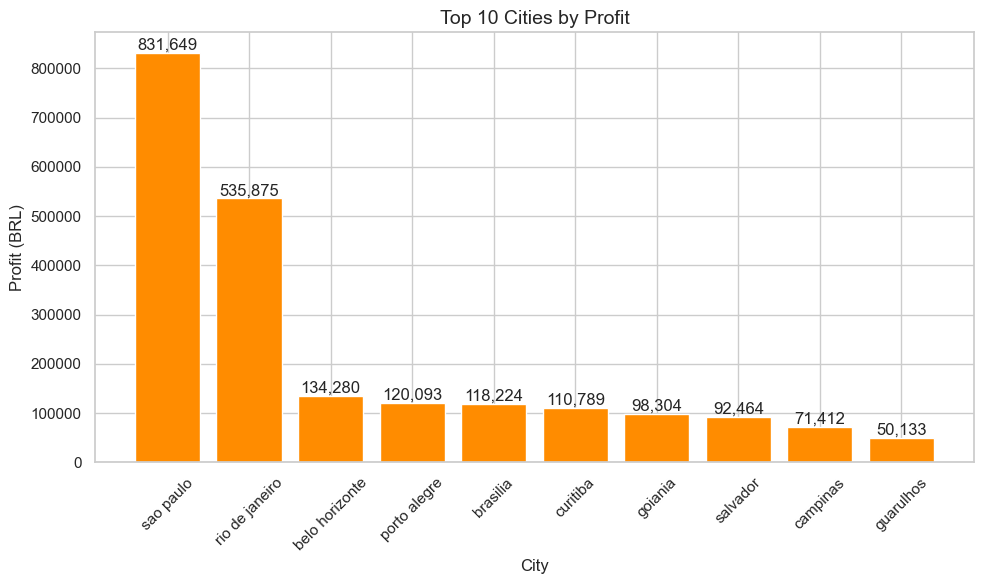

In [63]:


# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create the bar chart using city and profit columns
bars = plt.bar(df["City"], df["Profit"], color="darkorange")

# Add labels (profit values) above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
        height + 500,                      # Y position (a bit above the bar)
        f"{int(height):,}",                # Label (comma-separated number)
        ha='center', va='bottom'
    )

# Add axis labels and title
plt.xlabel("City", fontsize=12)
plt.ylabel("Profit (BRL)", fontsize=12)
plt.title("Top 10 Cities by Profit", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Optimize layout so nothing gets cut off
plt.tight_layout()

# Display the plot
plt.show()


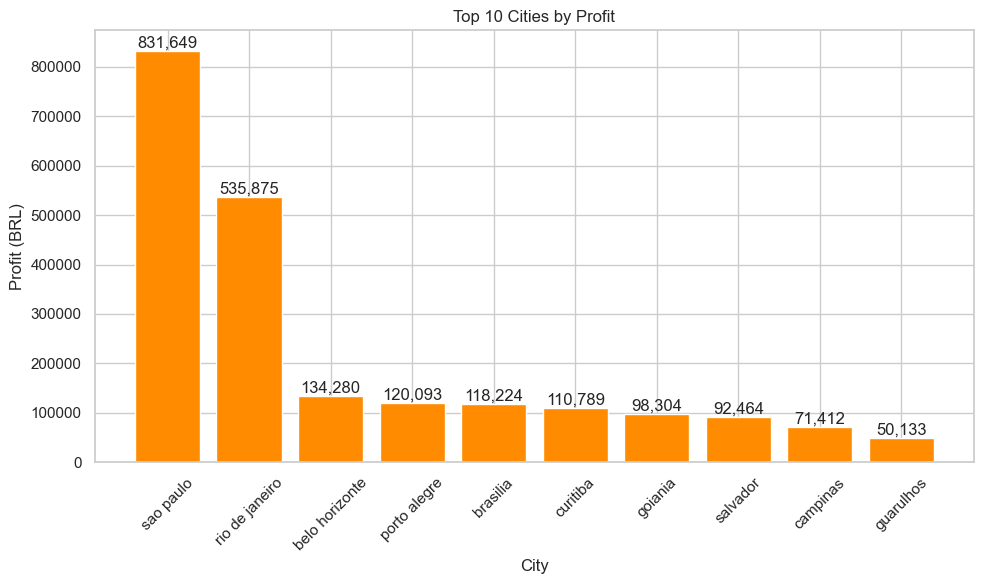

In [64]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df["City"], df["Profit"], color="darkorange")

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f"{int(yval):,}", ha='center', va='bottom')

plt.xlabel("City")
plt.ylabel("Profit (BRL)")
plt.title("Top 10 Cities by Profit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### group by profit percentage

In [65]:
query = """
SELECT 
    olist_customers_dataset.customer_city AS City,
    COUNT(DISTINCT olist_orders_dataset.order_id) AS Total_Orders,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Total_Sales,
    ROUND(SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price), 2) AS Profit,
    ROUND(
        (SUM(olist_order_payments_dataset.payment_value - olist_order_items_dataset.price) / 
         NULLIF(SUM(olist_order_payments_dataset.payment_value), 0)) * 100, 
        2
    ) AS Profit_Percentage
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
    ON olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
JOIN 
    olist_order_items_dataset 
    ON olist_orders_dataset.order_id = olist_order_items_dataset.order_id
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    olist_customers_dataset.customer_city
ORDER BY 
    Profit_Percentage DESC
LIMIT 10;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["City", "Total_Orders", "Total_Sales", "Profit", "Profit_Percentage"])
df



,City,Total_Orders,Total_Sales,Profit,Profit_Percentage
0,celso ramos,2,15157.63,14020.84,92.50
1,alto paraiso de goias,9,14520.23,13152.89,90.58
2,inconfidentes,2,961.97,861.98,89.61
3,cicero dantas,10,26425.26,23347.24,88.35
4,curralinho,1,1421.16,1232.40,86.72
5,padre carvalho,1,4080.58,3517.58,86.20
6,morro agudo,10,13347.79,11496.84,86.13
7,datas,1,5525.64,4745.64,85.88
8,matias olimpio,1,4207.00,3607.00,85.74
9,brasileia,1,418.59,358.89,85.74


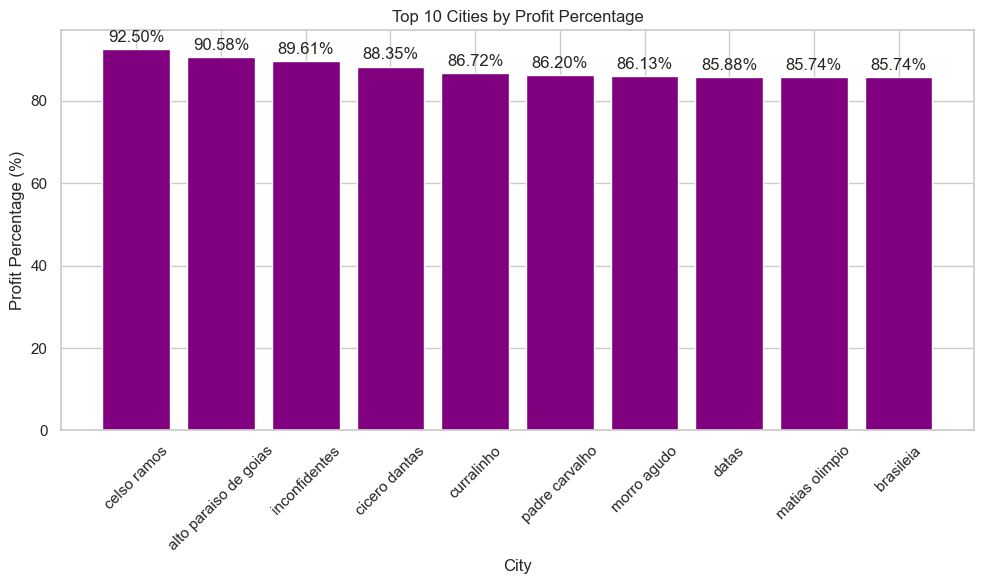

In [66]:
# Sort by Profit Percentage (just in case)
df_sorted_percent = df.sort_values("Profit_Percentage", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df_sorted_percent["City"], df_sorted_percent["Profit_Percentage"], color="purple")

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

plt.xlabel("City")
plt.ylabel("Profit Percentage (%)")
plt.title("Top 10 Cities by Profit Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### List the top 10 cities with the highest number of orders.

In [29]:
query = """
SELECT 
    olist_customers_dataset.customer_city AS city,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS total_sales,
    ROUND(SUM(olist_order_items_dataset.price - olist_order_items_dataset.freight_value), 2) AS profit
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
    ON olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
JOIN 
    olist_order_items_dataset 
    ON olist_orders_dataset.order_id = olist_order_items_dataset.order_id
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    city
ORDER BY 
    total_sales DESC
LIMIT 10
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["City", "Total_Sales", "Profit"])
df


,City,Total_Sales,Profit
0,sao paulo,2839903.47,1740898.18
1,rio de janeiro,1566591.49,860205.13
2,belo horizonte,501261.50,303502.06
3,brasilia,430499.43,260433.98
4,curitiba,329321.54,184405.40
5,porto alegre,315729.22,161294.44
6,salvador,289139.66,157803.17
7,campinas,267039.20,169618.13
8,goiania,212702.97,95395.50
9,guarulhos,205350.25,134587.25


In [39]:
query = """
SELECT 
    olist_customers_dataset.customer_city AS city,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS total_sales,
    ROUND(SUM(olist_order_items_dataset.price - olist_order_items_dataset.freight_value), 2) AS profit
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
    ON olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
JOIN 
    olist_order_items_dataset 
    ON olist_orders_dataset.order_id = olist_order_items_dataset.order_id
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    city
ORDER BY 
    profit DESC
LIMIT 10
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["City", "Total_Sales", "Profit"])
df["Profit_Percentage"] = round((df["Profit"] / df["Total_Sales"]) * 100, 2)
df


,City,Total_Sales,Profit,Profit_Percentage
0,sao paulo,2839903.47,1740898.18,61.30
1,rio de janeiro,1566591.49,860205.13,54.91
2,belo horizonte,501261.50,303502.06,60.55
3,brasilia,430499.43,260433.98,60.50
4,curitiba,329321.54,184405.40,56.00
5,campinas,267039.20,169618.13,63.52
6,porto alegre,315729.22,161294.44,51.09
7,salvador,289139.66,157803.17,54.58
8,guarulhos,205350.25,134587.25,65.54
9,niteroi,175199.18,110659.47,63.16


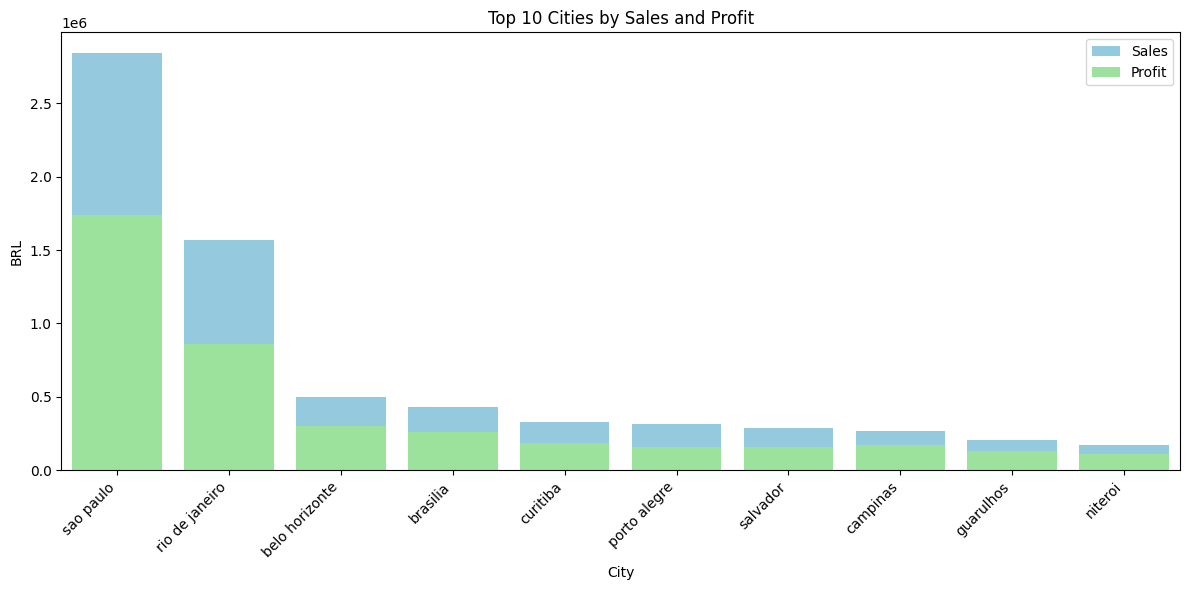

In [40]:
plt.figure(figsize=(12,6))
df_sorted = df.sort_values("Total_Sales", ascending=False)

# Bar chart for Sales
sns.barplot(data=df_sorted, x="City", y="Total_Sales", color='skyblue', label='Sales')

# Bar chart for Profit (overlay)
sns.barplot(data=df_sorted, x="City", y="Profit", color='lightgreen', label='Profit')

plt.title("Top 10 Cities by Sales and Profit")
plt.xticks(rotation=45, ha='right')
plt.ylabel("BRL")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Vikash\AppData\Local\Temp\ipykernel_10752\663881125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.sort_values('Profit_Percentage', ascending=False),


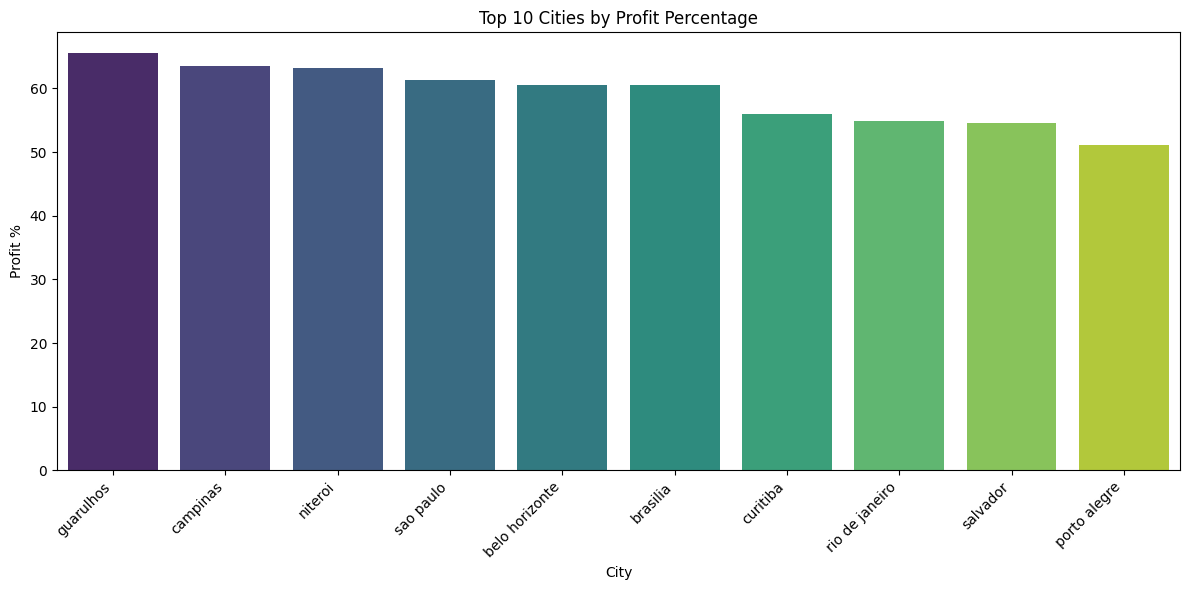

In [42]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.sort_values('Profit_Percentage', ascending=False),
            x='City', y='Profit_Percentage', palette='viridis',legend=False)
plt.title("Top 10 Cities by Profit Percentage")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Profit %")
plt.tight_layout()
plt.show()


In [33]:
query = """
SELECT 
    olist_customers_dataset.customer_state AS state,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS total_sales,
    ROUND(SUM(olist_order_items_dataset.price - olist_order_items_dataset.freight_value), 2) AS profit
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
    ON olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
JOIN 
    olist_order_items_dataset 
    ON olist_orders_dataset.order_id = olist_order_items_dataset.order_id
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    state
ORDER BY 
    total_sales DESC
LIMIT 10
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["State", "Total_Sales", "Profit"])
df

,State,Total_Sales,Profit
0,SP,7597209.66,4694815.57
1,RJ,2769347.44,1590150.21
2,MG,2326151.64,1358335.52
3,RS,1147277.00,646190.84
4,PR,1064603.99,583186.78
5,BA,797410.36,434872.58
6,SC,786343.71,445999.09
7,GO,513879.00,254596.69
8,DF,432623.73,260949.22
9,ES,405805.34,232505.36


In [37]:
df["Profit_Percentage"] = round((df["Profit"] / df["Total_Sales"]) * 100, 2)
df


,State,Total_Sales,Profit,Profit_Percentage
0,SP,7597209.66,4694815.57,61.80
1,RJ,2769347.44,1590150.21,57.42
2,MG,2326151.64,1358335.52,58.39
3,RS,1147277.00,646190.84,56.32
4,PR,1064603.99,583186.78,54.78
5,BA,797410.36,434872.58,54.54
6,SC,786343.71,445999.09,56.72
7,GO,513879.00,254596.69,49.54
8,DF,432623.73,260949.22,60.32
9,ES,405805.34,232505.36,57.29


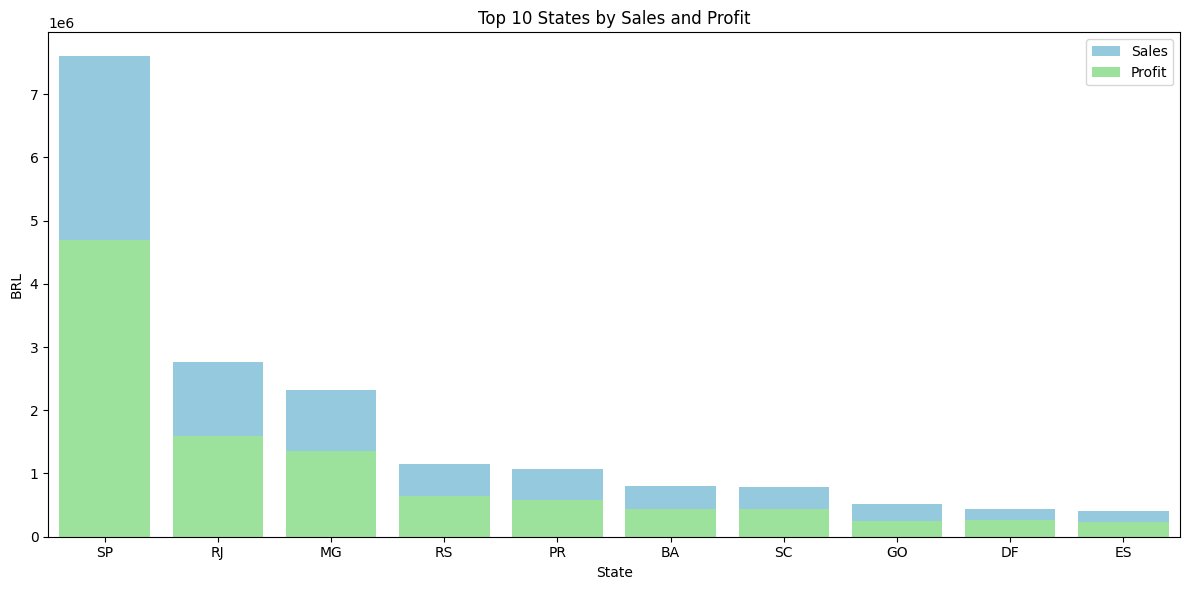

In [35]:
plt.figure(figsize=(12,6))
df_sorted = df.sort_values("Total_Sales", ascending=False)

sns.barplot(data=df_sorted, x="State", y="Total_Sales", color='skyblue', label='Sales')
sns.barplot(data=df_sorted, x="State", y="Profit", color='lightgreen', label='Profit')

plt.title("Top 10 States by Sales and Profit")
plt.ylabel("BRL")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Vikash\AppData\Local\Temp\ipykernel_10752\3778119750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.sort_values('Profit_Percentage', ascending=False),


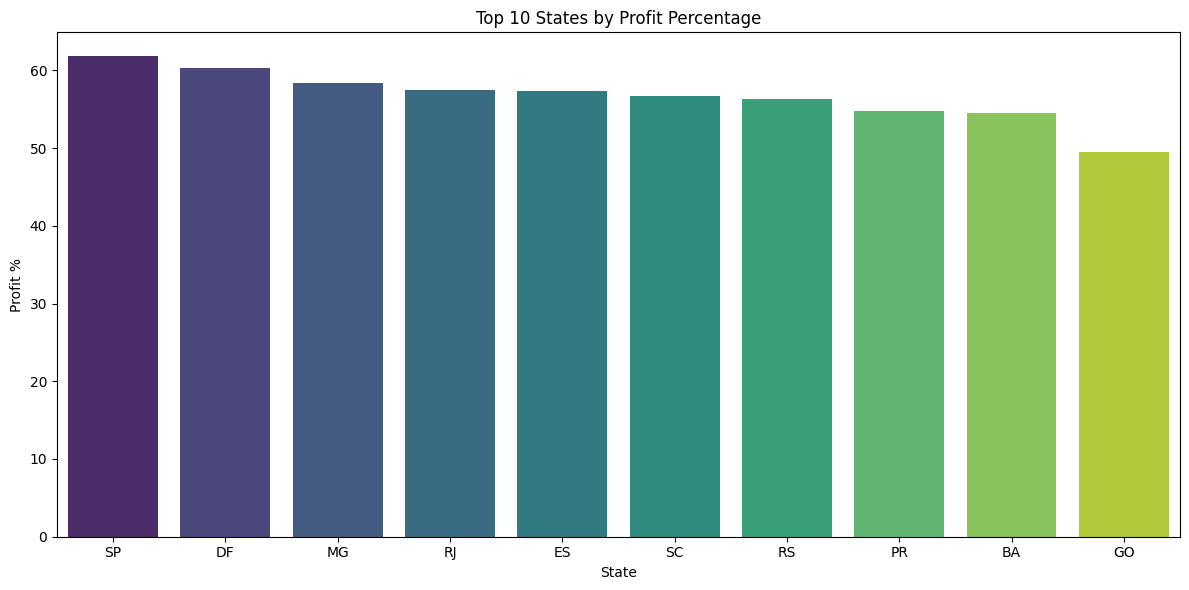

In [38]:
plt.figure(figsize=(12,6))
sns.barplot(data=df.sort_values('Profit_Percentage', ascending=False),
            x='State', y='Profit_Percentage', palette='viridis')

plt.title("Top 10 States by Profit Percentage")
plt.ylabel("Profit %")
plt.tight_layout()
plt.show()


### 5. Count the number of reviews with each rating (1 to 5).

In [10]:
query = """
SELECT review_score, COUNT(review_id)
FROM olist_order_reviews_dataset
GROUP BY review_score
"""

cur.execute(query)
data = cur.fetchall()

# Fix column order: review_score first
df = pd.DataFrame(data, columns=["Review_Score", "Review_Count"])
df


,Review_Score,Review_Count
0,4,19142
1,5,57328
2,1,11424
3,3,8179
4,2,3151


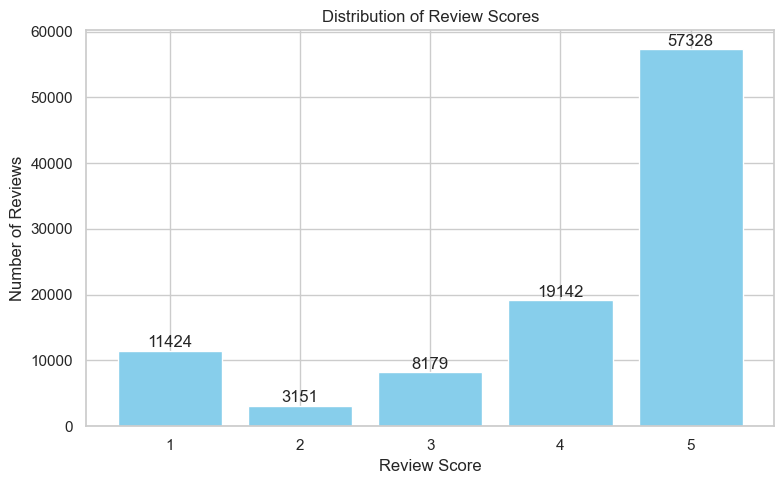

In [71]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(df["Review_Score"], df["Review_Count"], color="skyblue")

# Add labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f"{int(height)}", ha='center', va='bottom')

plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores")
plt.xticks(df["Review_Score"])  # Ensure only 1 to 5 ticks
plt.tight_layout()
plt.show()


### 6. Find the earliest and latest order dates in the dataset.

In [115]:
query = """ select order_id, date(order_purchase_timestamp) as earliest
from olist_orders_dataset
order by earliest
limit 1;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","earliest_date_of_order"])
df

,order_id,earliest_date_of_order
0,2e7a8482f6fb09756ca50c10d7bfc047,2016-09-04


In [16]:
query = """ select order_id, date(order_purchase_timestamp) as latest
from olist_orders_dataset
order by latest desc
limit 1;
; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["order_id","latest_date_of_order"])
df

,order_id,latest_date_of_order
0,10a045cdf6a5650c21e9cfeb60384c16,2018-10-17


### 1. Calculate average delivery time (from order to delivered date).

In [18]:
query = """
SELECT 
    ROUND(AVG(DATEDIFF(order_delivered_customer_date, order_purchase_timestamp)), 2) AS avg_delivery_days
FROM 
    olist_orders_dataset
WHERE 
    order_status = 'delivered' 
    AND order_delivered_customer_date IS NOT NULL
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Average_Delivery_Days"])
df


,Average_Delivery_Days
0,12.50


### 2. Find the average review score by product category.

In [43]:
query = """ select olist_products_dataset.product_category_name, avg(olist_order_reviews_dataset.review_score) as avg_prod_review
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_reviews_dataset
on olist_order_reviews_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name;
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_category_name","avg_prod_review"])
df

,product_category_name,avg_prod_review
0,relogios_presentes,4.0192
1,livros_tecnicos,4.3684
2,informatica_acessorios,3.9308
3,eletronicos,4.0375
4,esporte_lazer,4.1080
...,...,...
69,cds_dvds_musicais,4.6429
70,la_cuisine,4.0000
71,fashion_roupa_infanto_juvenil,4.5000
72,pc_gamer,3.3333


### 3. Find top 5 product categories with highest return (if available).

### 4. Analyze average payment value per order status.

In [82]:
query = """
SELECT 
    product_category_name_translation.product_category_name_english AS Category,
    ROUND(AVG(olist_order_payments_dataset.payment_value), 2) AS Avg_Payment_Value
FROM 
    olist_order_items_dataset
JOIN 
    olist_products_dataset 
    ON olist_order_items_dataset.product_id = olist_products_dataset.product_id
JOIN 
    olist_order_payments_dataset 
    ON olist_order_items_dataset.order_id = olist_order_payments_dataset.order_id
JOIN 
    product_category_name_translation 
    ON olist_products_dataset.product_category_name = product_category_name_translation.product_category_name
GROUP BY 
    product_category_name_translation.product_category_name_english
ORDER BY 
    Avg_Payment_Value DESC
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Avg_Payment_Value"])
df


,Category,Avg_Payment_Value
0,computers,1268.73
1,fixed_telephony,763.88
2,small_appliances_home_oven_and_coffee,656.79
3,agro_industry_and_commerce,471.15
4,home_appliances_2,464.79
...,...,...
66,fashion_underwear_beach,88.30
67,food,88.27
68,cds_dvds_musicals,85.67
69,flowers,67.06


In [83]:
### OR

In [5]:
query = """ select olist_products_dataset.product_category_name as category, round(avg(olist_order_payments_dataset.payment_value),2) as avg_payment
from olist_products_dataset join olist_order_items_dataset
on olist_products_dataset.product_id = olist_order_items_dataset.product_id
join olist_order_payments_dataset
on olist_order_payments_dataset.order_id = olist_order_items_dataset.order_id
group by product_category_name
"""
cur.execute(query)
data = cur.fetchall()
data
# and if i want to dataframe
df = pd.DataFrame(data, columns = ["Catogory", "avg_payment"])
df

,Catogory,avg_payment
0,perfumaria,142.34
1,moveis_decoracao,163.56
2,telefonia,103.13
3,fashion_bolsas_e_acessorios,101.42
4,cama_mesa_banho,144.85
...,...,...
69,cds_dvds_musicais,85.67
70,la_cuisine,182.10
71,fashion_roupa_infanto_juvenil,98.21
72,pc_gamer,217.44


In [80]:
query = """
SELECT 
    olist_orders_dataset.order_status AS Order_Status,
    ROUND(AVG(olist_order_payments_dataset.payment_value), 2) AS Avg_Payment_Value
FROM 
    olist_orders_dataset
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    olist_orders_dataset.order_status
ORDER BY 
    Avg_Payment_Value DESC
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Order_Status", "Avg_Payment_Value"])
df

,Order_Status,Avg_Payment_Value
0,processing,217.54
1,canceled,215.75
2,invoiced,212.73
3,unavailable,194.88
4,delivered,153.07
5,shipped,151.98
6,created,137.62
7,approved,120.54


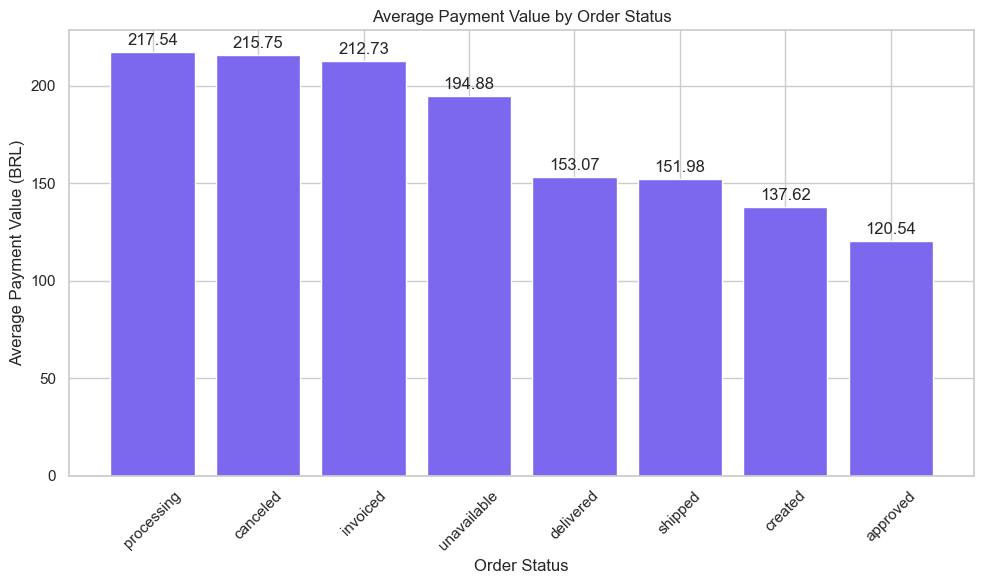

In [81]:
import matplotlib.pyplot as plt

# Sort the data for better visual order (highest to lowest)
df_sorted = df.sort_values("Avg_Payment_Value", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df_sorted["Order_Status"], df_sorted["Avg_Payment_Value"], color="mediumslateblue")

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f"{height:.2f}", ha='center', va='bottom')

# Customize chart
plt.xlabel("Order Status")
plt.ylabel("Average Payment Value (BRL)")
plt.title("Average Payment Value by Order Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 5. Identify the number of sellers with sales above a certain threshold.

###  1. Predict average delivery time per region using historical data.

In [74]:
state_region_map = {
    'AC': 'North', 'AP': 'North', 'AM': 'North', 'PA': 'North', 'RO': 'North', 'RR': 'North', 'TO': 'North',
    'AL': 'Northeast', 'BA': 'Northeast', 'CE': 'Northeast', 'MA': 'Northeast', 'PB': 'Northeast',
    'PE': 'Northeast', 'PI': 'Northeast', 'RN': 'Northeast', 'SE': 'Northeast',
    'DF': 'Central-West', 'GO': 'Central-West', 'MT': 'Central-West', 'MS': 'Central-West',
    'ES': 'Southeast', 'MG': 'Southeast', 'RJ': 'Southeast', 'SP': 'Southeast',
    'PR': 'South', 'RS': 'South', 'SC': 'South'
}


In [78]:
query = """
SELECT 
    olist_customers_dataset.customer_state AS State,
    ROUND(AVG(DATEDIFF(olist_orders_dataset.order_delivered_customer_date, olist_orders_dataset.order_purchase_timestamp)), 2) AS Avg_Delivery_Days
FROM 
    olist_orders_dataset
JOIN 
    olist_customers_dataset 
    ON olist_orders_dataset.customer_id = olist_customers_dataset.customer_id
WHERE 
    olist_orders_dataset.order_status = 'delivered'
    AND olist_orders_dataset.order_delivered_customer_date IS NOT NULL
GROUP BY 
    olist_customers_dataset.customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["State", "Avg_Delivery_Days"])

df["Region"] = df["State"].map(state_region_map)

region_df = df.groupby("Region")["Avg_Delivery_Days"].mean().reset_index()
region_df = region_df.sort_values("Avg_Delivery_Days", ascending=False)
region_df


,Region,Avg_Delivery_Days
1,North,23.498571
2,Northeast,20.594444
0,Central-West,15.495
3,South,14.03
4,Southeast,12.9


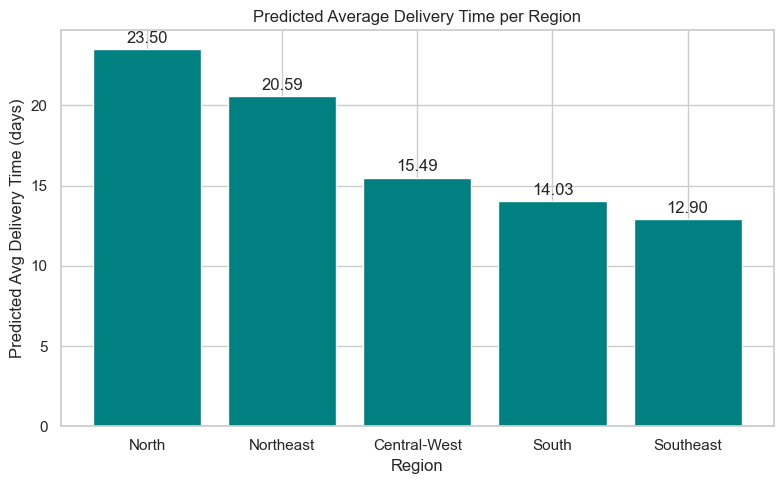

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bars = plt.bar(region_df["Region"], region_df["Avg_Delivery_Days"], color="teal")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{yval:.2f}", ha='center', va='bottom')

plt.xlabel("Region")
plt.ylabel("Predicted Avg Delivery Time (days)")
plt.title("Predicted Average Delivery Time per Region")
plt.tight_layout()
plt.show()


In [9]:
###  2. Cluster customers based on total spending and number of orders.

In [8]:
###  3. Analyze refund or cancellation patterns (if status column allows).

In [ ]:
###  4. Identify peak sales hours (if timestamp available).

### 

### Top 5 States by Number of Orders

In [14]:
query = """
SELECT 
    olist_customers_dataset.customer_state AS state,
    COUNT(DISTINCT olist_orders_dataset.order_id) AS total_orders
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
ON 
    olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
GROUP BY 
    olist_customers_dataset.customer_state
ORDER BY 
    total_orders DESC
LIMIT 5
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["State", "Total_Orders"])
df


,State,Total_Orders
0,SP,41746
1,RJ,12852
2,MG,11635
3,RS,5466
4,PR,5045


C:\Users\Vikash\AppData\Local\Temp\ipykernel_20352\1581246605.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="State", y="Total_Orders", palette="Blues_d")


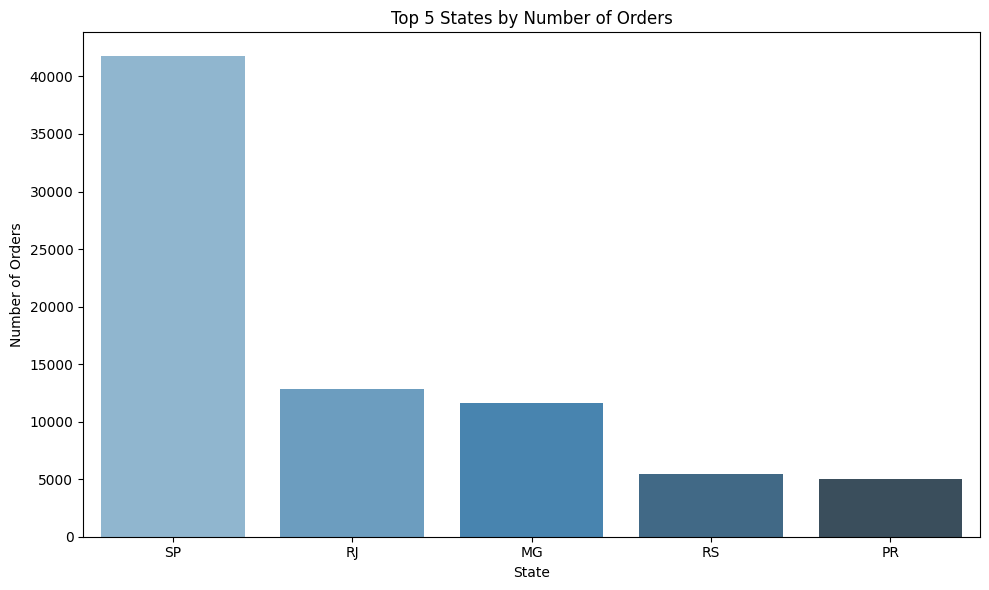

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by Total_Orders descending
df_sorted = df.sort_values("Total_Orders", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="State", y="Total_Orders", palette="Blues_d")

plt.title("Top 5 States by Number of Orders")
plt.xlabel("State")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


## D. Customer Review Analysis

### Average review score by product category

In [27]:
query = """
SELECT 
    product_category_name_translation.product_category_name_english AS Category,
    ROUND(AVG(olist_order_reviews_dataset.review_score), 2) AS Average_Review_Score
FROM 
    olist_order_reviews_dataset
JOIN 
    olist_orders_dataset 
    ON olist_order_reviews_dataset.order_id = olist_orders_dataset.order_id
JOIN 
    olist_order_items_dataset 
    ON olist_orders_dataset.order_id = olist_order_items_dataset.order_id
JOIN 
    olist_products_dataset 
    ON olist_order_items_dataset.product_id = olist_products_dataset.product_id
JOIN 
    product_category_name_translation 
    ON olist_products_dataset.product_category_name = product_category_name_translation.product_category_name
WHERE 
    olist_order_reviews_dataset.review_score IS NOT NULL
GROUP BY 
    product_category_name_translation.product_category_name_english
ORDER BY 
    Average_Review_Score DESC
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "Average_Review_Score"])
df



,Category,Average_Review_Score
0,cds_dvds_musicals,4.64
1,fashion_childrens_clothes,4.50
2,books_general_interest,4.45
3,costruction_tools_tools,4.44
4,flowers,4.42
...,...,...
66,fashion_male_clothing,3.64
67,home_comfort_2,3.63
68,office_furniture,3.49
69,diapers_and_hygiene,3.26


C:\Users\Vikash\AppData\Local\Temp\ipykernel_20352\3206592812.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Category", y="Average_Review_Score", palette="viridis")


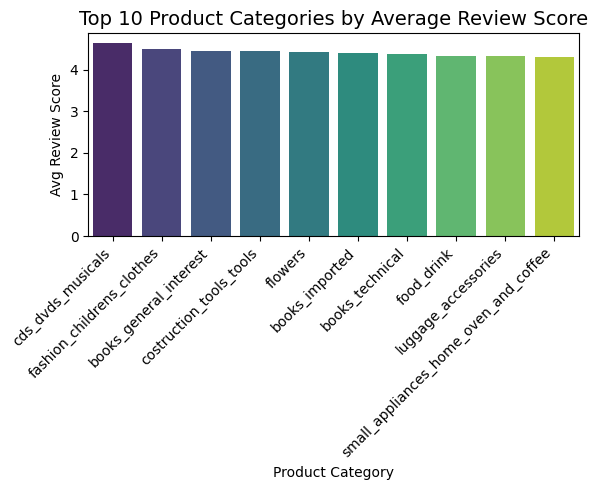

In [29]:
# Sort and take top 10
top10 = df.sort_values("Average_Review_Score", ascending=False).head(10)

plt.figure(figsize=(6,5))
sns.barplot(data=top10, x="Category", y="Average_Review_Score", palette="viridis")

plt.title("Top 10 Product Categories by Average Review Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Avg Review Score")
plt.xlabel("Product Category")
plt.tight_layout()
plt.show()

### List the top 10 state and state with the highest no of sales

In [12]:
query = """
SELECT 
    olist_customers_dataset.customer_state AS State,
    ROUND(SUM(olist_order_payments_dataset.payment_value), 2) AS Total_Sales
FROM 
    olist_customers_dataset
JOIN 
    olist_orders_dataset 
    ON olist_customers_dataset.customer_id = olist_orders_dataset.customer_id
JOIN 
    olist_order_payments_dataset 
    ON olist_orders_dataset.order_id = olist_order_payments_dataset.order_id
GROUP BY 
    olist_customers_dataset.customer_state
ORDER BY 
    Total_Sales DESC
LIMIT 10
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["State", "Total_Sales"])
df


,State,Total_Sales
0,SP,5998226.96
1,RJ,2144379.69
2,MG,1872257.26
3,RS,890898.54
4,PR,811156.38
5,SC,623086.43
6,BA,616645.82
7,DF,355141.08
8,GO,350092.31
9,ES,325967.55
